In [1]:
import numpy as np
import scipy.stats
from matplotlib import pyplot as plt

plt.rcParams["figure.figsize"] = (10, 8)
plt.rcParams.update({'font.size': 14})

from cosmoprimo import *

from densitysplit import catalog_data, density_split
from densitysplit.split_model import *
from densitysplit.corr_func_utils import *

# To activate logging
setup_logging()

## Cosmology

In [2]:
z = 1.175

# Abacus summit base cosmology
cosmo_abacus = fiducial.AbacusSummitBase()
bg = cosmo_abacus.get_background()

k=np.logspace(-5, 3, 100000)

## General parameters

In [3]:
output_dir = '/feynman/work/dphp/mp270220/outputs/'

mock_catalog = catalog_data.Data.load(output_dir+'mocks/gaussian/AbacusSummit_2Gpc_z1.175_gaussianMock0_truncatedPk_nbarx5.npy')
nbar = mock_catalog.size/mock_catalog.boxsize**3

In [4]:
cellsize = 10
resampler = 'tsc'

## Split model

In [5]:
kN = np.pi*1024/mock_catalog.boxsize
kN

1.6084954386379742

In [6]:
def damping_function(k, k_lambda=0.8*kN, sigma_lambda=0.05*kN):
    if k < k_lambda:
        return 1
    else:
        return np.exp(-(k-k_lambda)**2/(2*sigma_lambda**2))

In [7]:
pklin = cosmo_abacus.get_fourier().pk_interpolator(extrap_kmin=1e-6, extrap_kmax=1e3).to_1d(z)
pklin_array = pklin(k)
pkdamped_func = lambda k: pklin(k) * np.array([damping_function(kk) for kk in k])
pkdamped = PowerSpectrumInterpolator1D.from_callable(k, pkdamped_func)

## 10 models with different shot noise values

In [8]:
shot_noise_list = np.linspace(0, 2000, 10)
models_list = list()
ccf_randoms_tracers_list = list()
ccf_tracers_list = list()

for i in range(len(shot_noise_list)):
    model = SplitCCFModel(k, redshift=z, cosmology=cosmo_abacus, bias=1.8, nsplits=1, shot_noise=shot_noise_list[i])
    model.set_pk_model(pk=pkdamped)
    models_list.append(model)
    th_bins = scipy.stats.norm.ppf(q=[0, 1./3, 2./3, 1], loc=0, scale=model.sigma_RR)
    bins = np.array([-3.09689824, -0.2246935 ,  0.2390149 ,  3.38778787])
    bins = th_bins
    ccf_randoms_tracers_list.append(model.ccf_randoms_tracers(density_bins=bins))
    ccf_tracers_list.append(model.ccf_tracers(density_bins=bins))

In [9]:
th_bins

array([       -inf, -0.26368644,  0.26368644,         inf])

## Plot density split CCFs (randoms-tracers)

In [10]:
cmap = plt.get_cmap('plasma')

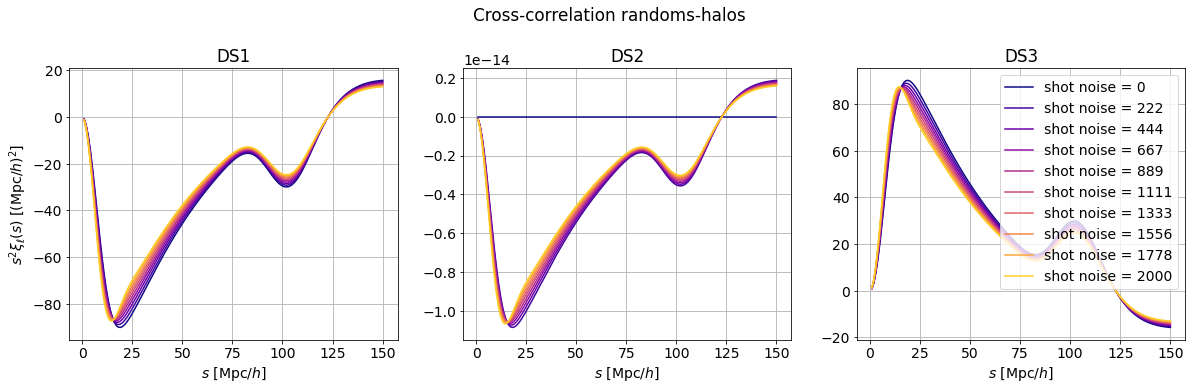

In [13]:
plt.rcParams["figure.figsize"] = (20, 5)
plt.rcParams.update({'font.size': 14})

fig, axes = plt.subplots(1, 3, sharex=False, sharey=False)

s = model.sep

for i in range(model.nsplits):
    for j in range(len(shot_noise_list)):
        axes[i].plot(s, s**2 * ccf_randoms_tracers_list[j][i], label='shot noise = {:.0f}'.format(shot_noise_list[j]), color=cmap(j/len(shot_noise_list)))
        axes[i].grid(True)
        axes[i].set_title('DS{}'.format(i+1))    
        axes[i].set_xlabel(r'$s$ [$\mathrm{Mpc}/h$]')

axes[0].set_ylabel(r'$s^2 \xi_{\ell}(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
axes[2].legend()

plt.suptitle('Cross-correlation randoms-halos', y=1.05)
plt.show()

## Plot density split CCFs (tracers-tracers)

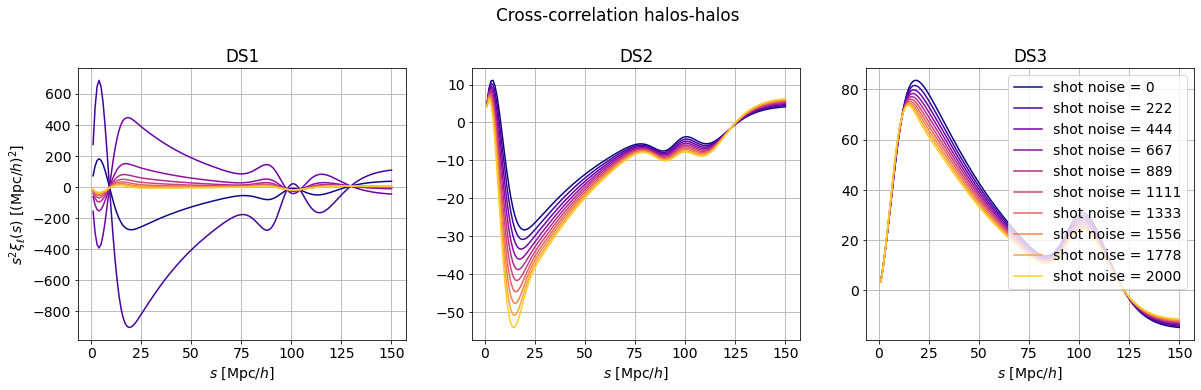

In [12]:
plt.rcParams["figure.figsize"] = (20, 5)
plt.rcParams.update({'font.size': 14})

fig, axes = plt.subplots(1, 3, sharex=False, sharey=False)

s = model.sep

for i in range(model.nsplits):
    for j in range(len(shot_noise_list)):
        axes[i].plot(s, s**2 * ccf_tracers_list[j][i], label='shot noise = {:.0f}'.format(shot_noise_list[j]), color=cmap(j/len(shot_noise_list)))
        axes[i].grid(True)
        axes[i].set_title('DS{}'.format(i+1))    
        axes[i].set_xlabel(r'$s$ [$\mathrm{Mpc}/h$]')

axes[0].set_ylabel(r'$s^2 \xi_{\ell}(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
axes[2].legend()

plt.suptitle('Cross-correlation halos-halos', y=1.05)
plt.show()